In [1]:
%matplotlib notebook

import numpy as np
import pandas as pd
import pymongo as pm
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
import dateutil.parser as prs

In [2]:
# connect to MongoDB cluster

conn_str = "mongodb://127.0.0.1/clintrials"

client = pm.MongoClient(conn_str)

client["admin"].command("listDatabases")

{'databases': [{'empty': False, 'name': 'admin', 'sizeOnDisk': 32768.0},
  {'empty': False, 'name': 'clintrials', 'sizeOnDisk': 1774030848.0},
  {'empty': False, 'name': 'config', 'sizeOnDisk': 73728.0},
  {'empty': False, 'name': 'genomics', 'sizeOnDisk': 3624493056.0},
  {'empty': False, 'name': 'local', 'sizeOnDisk': 73728.0},
  {'empty': False, 'name': 'test', 'sizeOnDisk': 32768.0}],
 'ok': 1.0,
 'totalSize': 5398736896.0}

In [3]:
# define "db" and "coll" variables for convenience

db = client["clintrials"]
coll = db["clinical_studies"]

client["clintrials"].command("listCollections")

{'cursor': {'firstBatch': [{'idIndex': {'key': {'_id': 1},
     'name': '_id_',
     'ns': 'clintrials.clinical_studies',
     'v': 2},
    'info': {'readOnly': False,
     'uuid': UUID('caf7b00d-2293-42d6-8443-b0d3c4655b65')},
    'name': 'clinical_studies',
    'options': {},
    'type': 'collection'}],
  'id': 0,
  'ns': 'clintrials.$cmd.listCollections'},
 'ok': 1.0}

In [4]:
# Grab a single record to get a sense of schema

doc = coll.find_one()
doc

{'_id': ObjectId('5abe7daaad81112456d150b0'),
 'brief_summary': {'textblock': 'The purpose of this study is to see if we can develop a good graft for oral mucosal tissue\n      that is like the top of the mouth in a "test tube" that could be used successfully in humans.\n      We have already done this successfully mice. The next step is to take a small piece of tissue\n      from a human volunteer and see if we can grow a larger piece of tissue from it outside the\n      human body and graft it back into the same person successfully. We expect that this technique\n      will work. It has already been tried in patients with burns of the skin who have had similar\n      procedures where the skin is grafted back to them. The significance of this research is that\n      oral tissue taken from the top of the mouth or palate is in limited supply and leaves the\n      patient with a painful and uncomfortable post surgery experience. If we are successful with\n      our technique the patient 

In [5]:
# Inspect the data to determine values for an implicit enum

coll.distinct("overall_status")

['Unknown status',
 'Completed',
 'Terminated',
 'Active, not recruiting',
 'Withdrawn',
 'Recruiting',
 'Enrolling by invitation',
 'Suspended',
 'Approved for marketing',
 'No longer available',
 'Not yet recruiting',
 'Withheld',
 'Available',
 'Temporarily not available']

In [6]:
# Example of getting some basic aggregation data
list(coll.aggregate([
    {"$group": {"_id": "$condition", "n": {"$sum": 1}}}
    ,{"$sort": {"n" : -1}}
    ,{"$limit": 10}
]))

[{'_id': 'Healthy', 'n': 5608},
 {'_id': 'Breast Cancer', 'n': 3224},
 {'_id': 'Prostate Cancer', 'n': 1926},
 {'_id': 'Asthma', 'n': 1865},
 {'_id': 'HIV Infections', 'n': 1799},
 {'_id': 'Obesity', 'n': 1618},
 {'_id': 'Hypertension', 'n': 1357},
 {'_id': 'Rheumatoid Arthritis', 'n': 1238},
 {'_id': 'Coronary Artery Disease', 'n': 1171},
 {'_id': 'Schizophrenia', 'n': 1133}]

In [7]:
# Example of using a dataframe
pd.DataFrame(list(coll.aggregate([
    {"$group": {"_id": "$condition", "n": {"$sum": 1}}}
    ,{"$sort": {"n" : -1}}
    ,{"$limit": 10}
])))

,_id,n
0,Healthy,5608
1,Breast Cancer,3224
2,Prostate Cancer,1926
3,Asthma,1865
4,HIV Infections,1799
5,Obesity,1618
6,Hypertension,1357
7,Rheumatoid Arthritis,1238
8,Coronary Artery Disease,1171
9,Schizophrenia,1133


In [8]:
data = list(coll.aggregate([
    {"$addFields": {"startDate" : {"$dateFromString": {"dateString" : "$study_first_submitted"}}} }
    ,{"$group": {"_id": "$condition", "n": {"$sum": 1}, "startDates": {"$push": "$startDate"}}}
    ,{"$sort": {"n" : -1}}
    ,{"$limit": 10}
]))

In [9]:
start = prs.parse('1998-01-01').timestamp()
end = prs.parse('2018-05-01').timestamp()
bins = np.linspace(start, end, 100)

In [10]:
pd.Timestamp(data[0]['startDates'][0]).value
data[0]['startDates'][0].timestamp()

941605200.0

<IPython.core.display.Javascript object>


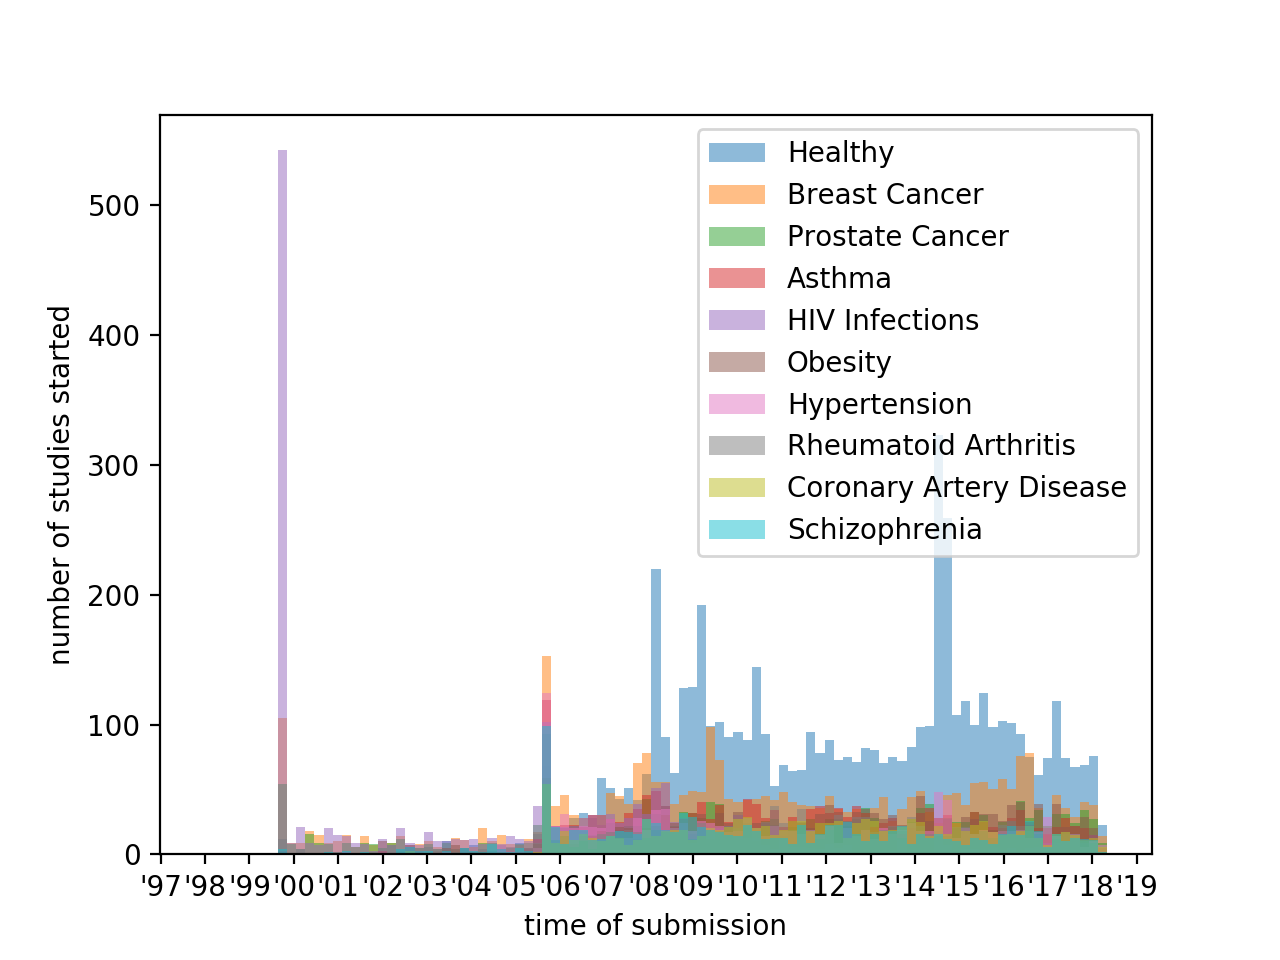

In [11]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,1)

for disease in data:
    plt.hist(mdates.epoch2num([x.timestamp() for x in disease['startDates']])
             , mdates.epoch2num(bins)
             , alpha=0.5, label=disease['_id'])

ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('\'%y'))

ax.set_ylabel('number of studies started')
ax.set_xlabel('time of submission')

plt.legend(loc='upper right')
plt.show()

<IPython.core.display.Javascript object>


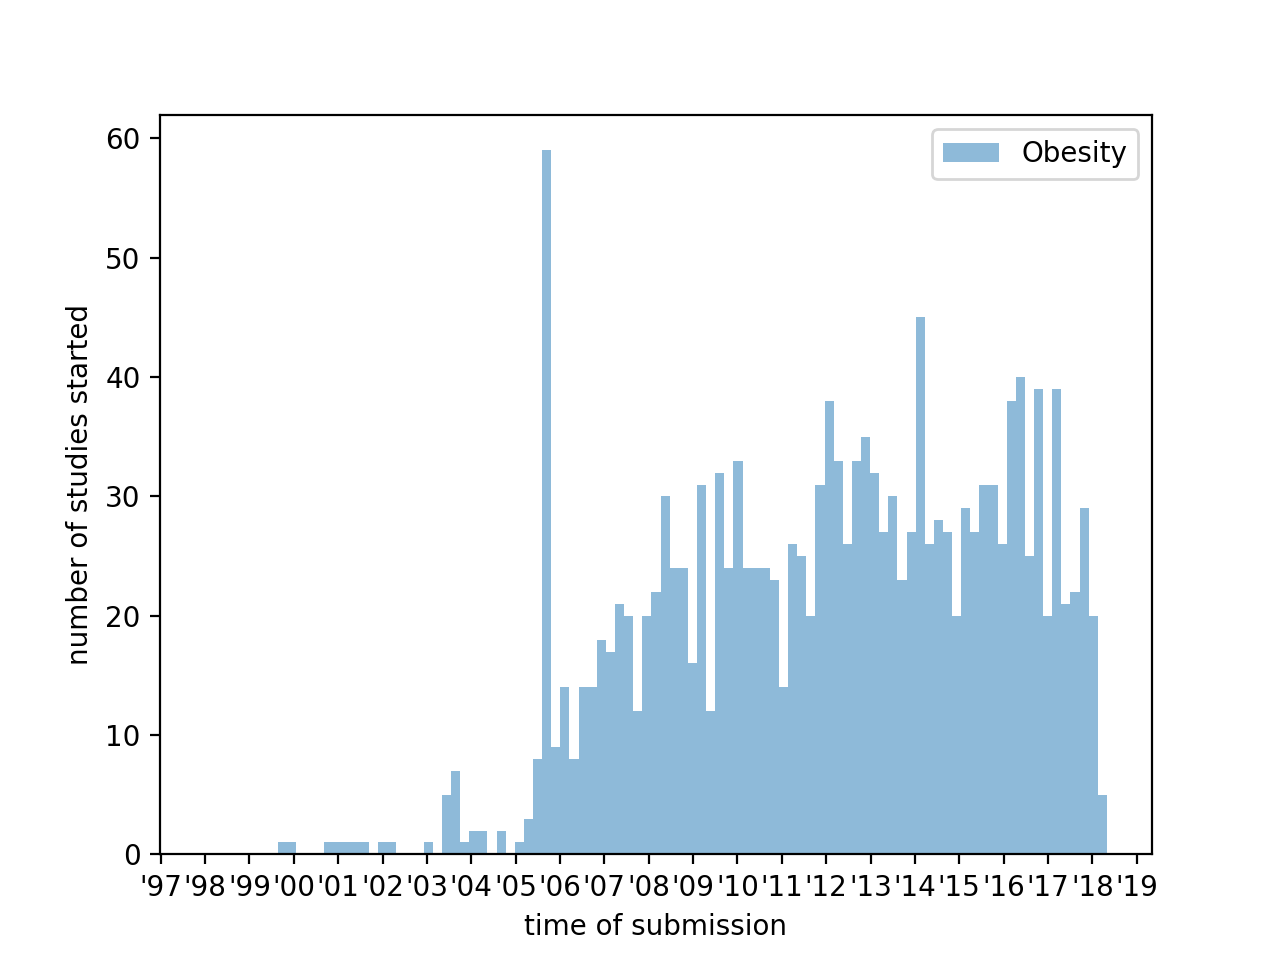

In [12]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,1)

for disease in [data[5]]:
    plt.hist(mdates.epoch2num([x.timestamp() for x in disease['startDates']])
             , mdates.epoch2num(bins)
             , alpha=0.5, label=disease['_id'])

ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('\'%y'))

ax.set_ylabel('number of studies started')
ax.set_xlabel('time of submission')

plt.legend(loc='upper right')
plt.show()